# FPI Tutorial

In [20]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import h5py
import matplotlib.pyplot as plt

asi_directory = 'MANGO_Data'

## Helper Functions

In [12]:
def mangofpi_to_xarray(data_array):
    """
    Convert a structured array of MangoFPI data read from Madrigal HDF5 into an xarray Dataset.

    Parameters:
    data_array (np.recarray): Input structured array containing MangoFPI data with time and measurement fields.

    Returns:
    xarray.Dataset: The converted xarray Dataset with appropriately named variables and attributes.
    """
    # Extract time components and create time dimension
    time_dimension = create_time_dimension(data_array['year'], data_array['month'], data_array['day'],
                                           data_array['hour'], data_array['min'], data_array['sec'])

    # Create xarray Dataset
    data_vars = {
        name: (('time',), data_array[name]) 
        for name in data_array.dtype.names if name not in ['year', 'month', 'day', 'hour', 'min', 'sec']
    }
    xr_dataset = xr.Dataset(data_vars, coords={'time': time_dimension})

    # Set attributes for each variable
    xr_dataset.elm.attrs['units'] = 'Degrees'
    xr_dataset.elm.attrs['description'] = 'Elevation angle (0=horizontal;90=vertical)'
    xr_dataset.azm.attrs['units'] = 'Degrees'
    xr_dataset.azm.attrs['description'] = 'Mean azimuth angle (0=geographic north;90=east)'
    xr_dataset.vnu.attrs['units'] = 'm/s'
    xr_dataset.vnu.attrs['description'] = 'Line of sight neutral velocity (positive = away)'
    xr_dataset.dvnu.attrs['units'] = 'm/s'
    xr_dataset.dvnu.attrs['description'] = 'Error in line of sight neutral velocity'
    xr_dataset.tn.attrs['units'] = 'K'
    xr_dataset.tn.attrs['description'] = 'Neutral atmosphere temperature (Tn)'
    xr_dataset.dtn.attrs['units'] = 'K'
    xr_dataset.dtn.attrs['description'] = 'Error in neutral atmosphere temperature (Tn)'
    xr_dataset.gdalt.attrs['units'] = 'km'
    xr_dataset.gdalt.attrs['description'] = 'Geodetic altitude (height)'
    xr_dataset.rlel.attrs['units'] = 'N/A'
    xr_dataset.rlel.attrs['description'] = 'Log10 relative (uncalibrated) emission'
    xr_dataset.cloudind.attrs['units'] = 'C'
    xr_dataset.cloudind.attrs['description'] = 'Ambient temperature - sky temperature. < -25 implies clear'
    xr_dataset.temp_err.attrs['units'] = 'N/A'
    xr_dataset.temp_err.attrs['description'] = 'Temperature flag: 0=ok; 1=caution; 2=likely bad'
    xr_dataset.wind_err.attrs['units'] = 'N/A'
    xr_dataset.wind_err.attrs['description'] = 'Wind flag: 0=ok; 1=caution; 2=likely bad'
    xr_dataset.doppl_ref.attrs['units'] = 'N/A'
    xr_dataset.doppl_ref.attrs['description'] = 'Doppler calibration: 1=laser; 0=no vertical winds'
    xr_dataset.fit_sigma.attrs['units'] = 'm/s'
    xr_dataset.fit_sigma.attrs['description'] = 'Wind uncertainty - least squares fit to sky fringes'
    xr_dataset.cal_sigma.attrs['units'] = 'm/s'
    xr_dataset.cal_sigma.attrs['description'] = 'Wind uncertainty - fluctuation in calibration source'

    # Drop unnecessary variables from the Dataset
    xr_dataset = xr_dataset.drop_vars(['recno', 'kindat', 'kinst', 'dgdalt', 'drlel'])

    return xr_dataset

def create_time_dimension(year, month, day, hour, minute, second):
    """
    Convert separate time-related components into a single datetime64 array.

    Parameters:
    year (np.ndarray): Array of year values.
    month (np.ndarray): Array of month values.
    day (np.ndarray): Array of day values.
    hour (np.ndarray): Array of hour values.
    minute (np.ndarray): Array of minute values.
    second (np.ndarray): Array of second values.

    Returns:
    np.ndarray: A numpy array of datetime64[ns] values.
    """
    # Ensure all inputs are appropriately formatted and zero-padded
    datetime_strings = [
        f"{int(y):04d}-{int(mo):02d}-{int(d):02d}T{int(h):02d}:{int(mi):02d}:{int(s):02d}"
        for y, mo, d, h, mi, s in zip(year, month, day, hour, minute, second)
    ]

    # Convert the list of date-time strings to a numpy array with dtype 'datetime64[ns]'
    return np.array(datetime_strings, dtype='datetime64[ns]')

def DopplerReference(xr_array, vertical_mask, reference='laser'):
    """
    Calculate and add Doppler reference values to an xarray dataset based on a specified reference method.

    Parameters:
    xr_array (xarray.Dataset): The input dataset containing Doppler velocity ('vnu') and error ('dvnu') data.
    vertical_mask (xarray.DataArray): A mask array to identify vertical Doppler values.
    reference (str): The reference method to use ('laser' or 'zenith'). Defaults to 'laser'.

    Returns:
    xarray.Dataset: The input dataset with added Doppler reference values ('ref_Dop') and their uncertainties ('e_ref_Dop').
    """

    # Mask vertical values and drop NaNs
    clean_vertical_values = xr_array.vnu.where(vertical_mask).dropna(dim='time')
    clean_vertical_errors = xr_array.dvnu.where(vertical_mask).dropna(dim='time')

    # Process based on the requested Doppler reference
    if reference == 'zenith':
        # Interpolate the zenith Doppler values
        ref_Dop = clean_vertical_values.interp(time=xr_array.time)
        e_ref_Dop = clean_vertical_errors.interp(time=xr_array.time)
    elif reference == 'laser':
        # Use the mode statistic by finding value which minimizes Lp-norm of residual, for small p
        res = 0.1  # m/s, desired resolution
        p = 0.1  # norm

        # Find minimum weighted norm Doppler reference
        mxz = np.percentile(clean_vertical_values, 90)
        mnz = np.percentile(clean_vertical_values, 10)

        if mxz < mnz:
            # There aren't many samples. Just use actual min/max
            mxz = max(clean_vertical_values)
            mnz = min(clean_vertical_values)
        N = int((mxz - mnz) / res)

        if N > 1e6:
            # This is probably low-quality data, return the median value instead
            ref_Dop = xr.DataArray(np.median(clean_vertical_values) * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
            e_ref_Dop = xr.DataArray(np.median(clean_vertical_errors) * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
        else:
            dtest = np.linspace(mnz, mxz, N)
            cost = np.zeros(N)
            for j in range(N):
                d = dtest[j]

                # Doppler reference
                zcorr = clean_vertical_values - d

                # Evaluate metric
                cost[j] = sum(abs(zcorr / clean_vertical_errors) ** p)
            jstar = np.argmin(cost)
            offset = dtest[jstar]
            ref_Dop = xr.DataArray(offset * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
            e_ref_Dop = xr.DataArray(offset * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})

    xr_array['ref_Dop'] = ref_Dop
    xr_array['e_ref_Dop'] = e_ref_Dop

    return xr_array

def los_2_horizontal(xr_array, los_mask, vertical_mask, direction):
    """
    Convert line-of-sight Doppler velocities to horizontal velocities in specified directions.

    Parameters:
    xr_array (xarray.Dataset): The input dataset containing Doppler velocity ('vnu'), error ('dvnu'), Doppler reference ('ref_Dop'), and elevation angle ('elm') data.
    los_mask (xarray.DataArray): A mask array to identify line-of-sight Doppler values.
    vertical_mask (xarray.DataArray): A mask array to identify vertical Doppler values.
    direction (str): The direction for horizontal conversion ('east', 'west', 'north', 'south', or 'zenith').

    Returns:
    xarray.Dataset: The input dataset with added horizontal velocity components ('u', 'v', 'w') and their uncertainties ('ue', 've', 'we').
    """

    # Identify time samples in the line of sight (los) direction
    time_samples_los = xr_array.time.where(los_mask, drop=True)

    # Identify the los values (removing the Doppler reference), uncertainties, and elevation angles
    clean_los_values = xr_array.vnu.where(los_mask).dropna(dim='time') - xr_array.ref_Dop.where(los_mask).dropna(dim='time')
    clean_los_errors = xr_array.dvnu.where(los_mask).dropna(dim='time')
    clean_elm = xr_array.elm.where(los_mask).dropna(dim='time')

    # Identify vertical values (removing the Doppler reference) and uncertainties
    clean_vertical_values = xr_array.vnu.where(vertical_mask).dropna(dim='time') - xr_array.ref_Dop.where(vertical_mask).dropna(dim='time')
    clean_vertical_errors = xr_array.dvnu.where(vertical_mask).dropna(dim='time')

    # Interpolate vertical values onto the time samples in the los direction
    interpolated_vertical = clean_vertical_values.interp(time=time_samples_los)
    interpolated_vertical_errors = clean_vertical_errors.interp(time=time_samples_los)

    # Run the math
    horizontal = (clean_los_values - interpolated_vertical * np.cos(np.deg2rad(clean_elm))) / np.sin(np.deg2rad(clean_elm))
    horizontal_e = np.sqrt(clean_los_errors ** 2 + interpolated_vertical_errors ** 2 * np.cos(np.deg2rad(clean_elm)) ** 2) / np.sin(np.deg2rad(clean_elm))

    # Align the coordinates before assignment
    horizontal = horizontal.reindex(time=xr_array.time)
    horizontal_e = horizontal_e.reindex(time=xr_array.time)

    if direction in ['east', 'west']:
        # Initialize the 'u' variable in the xr_array if it does not exist
        if 'u' not in xr_array:
            xr_array['u'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 'ue' not in xr_array:
            xr_array['ue'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'u' variable at the correct time indices
        if direction == 'east':
            xr_array['u'] = xr_array['u'].where(~los_mask, other=horizontal)
            xr_array['ue'] = xr_array['ue'].where(~los_mask, other=horizontal_e)
        else:
            xr_array['u'] = xr_array['u'].where(~los_mask, other=-horizontal)
            xr_array['ue'] = xr_array['ue'].where(~los_mask, other=horizontal_e)

    elif direction in ['north', 'south']:
        # Initialize the 'v' variable in the xr_array if it does not exist
        if 'v' not in xr_array:
            xr_array['v'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 've' not in xr_array:
            xr_array['ve'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'v' variable at the correct time indices
        if direction == 'north':
            xr_array['v'] = xr_array['v'].where(~los_mask, other=horizontal)
            xr_array['ve'] = xr_array['ve'].where(~los_mask, other=horizontal_e)
        else:
            xr_array['v'] = xr_array['v'].where(~los_mask, other=-horizontal)
            xr_array['ve'] = xr_array['ve'].where(~los_mask, other=horizontal_e)

    elif direction == 'zenith':
        this_w = interpolated_vertical
        this_e = interpolated_vertical_errors

        # Align coordinates before assignment
        this_w = this_w.reindex(time=xr_array.time)
        this_e = this_e.reindex(time=xr_array.time)

        # Initialize the 'w' variable in the xr_array if it does not exist
        if 'w' not in xr_array:
            xr_array['w'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 'we' not in xr_array:
            xr_array['we'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'w' variable at the correct time indices
        xr_array['w'] = xr_array['w'].where(~los_mask, other=this_w)
        xr_array['we'] = xr_array['we'].where(~los_mask, other=this_e)

    return xr_array

## Download and Load FPI Data

Used madrigalWeb to download relevant FPI data from LOW. the globalDownload.py function can be obtained by:

`wget http://cedar.openmadrigal.org/static/distributionFiles/madrigalWeb-3.2.3.tar.gz`

`globalDownload.py --verbose --url=http://cedar.openmadrigal.org --outputDir=/tmp --user_fullname="Jonathan+Makela" --user_email=jmakela@illinois.edu --user_affiliation="University+of+Illinois" --format="hdf5" --startDate="05/10/2023" --endDate="05/12/2023" --inst=5555`

Alternatively, the following code block uses the [madrigalWeb](https://pypi.org/project/madrigalWeb/) python package to download the same data.  Note that it may take several minutes.

In [8]:
import madrigalWeb.madrigalWeb

#constants
madrigalUrl = 'http://cedar.openmadrigal.org'

user_fullname = 'Jonathan Makela'
user_email = 'jmakela@illinois.edu'
user_affiliation = 'University of Illinois'

# create the main object to get all needed info from Madrigal
madrigalObj = madrigalWeb.madrigalWeb.MadrigalData(madrigalUrl)

# Lowel FPI
code = 5555

expList = madrigalObj.getExperiments(code, 2023, 5, 10, 0, 0, 0, 2023, 5, 12, 0, 0, 0)

for exp in expList:

    fileList = madrigalObj.getExperimentFiles(exp.id)
    
    for file in fileList:

        outFile = os.path.join(asi_directory, os.path.basename(file.name))
        print(outFile)
        madrigalObj.downloadFile(file.name, outFile, user_fullname, user_email, user_affiliation, format='hdf5')


MANGO_Data/minime11_low_20230509.cedar.034.hdf5
MANGO_Data/minime11_low_20230509_xg.cedar.043.hdf5
MANGO_Data/minime11_low_20230510.cedar.034.hdf5
MANGO_Data/minime11_low_20230510_xg.cedar.042.hdf5


In [21]:
# f = os.path.join(asi_directory, 'minime11_low_20230510_xg.cedar.034.hdf5')
f = os.path.join(asi_directory, 'minime11_low_20230510_xg.cedar.042.hdf5')

# Open the HDF5 file
with h5py.File(f, 'r') as hdf5_file:
    # Access the dataset from the HDF5 file
    table_layout = hdf5_file['Data/Table Layout']
    
    # Read the data
    table_array = np.array(table_layout)
    
    # Convert to xarray Dataset
    xr_dataset = mangofpi_to_xarray(table_array)

## Convert from LoS to Horizontal Winds

In [14]:
# Define el/az coords for each direction and create masks
east = (xr_dataset.elm == 45.) & (xr_dataset.azm == 90)
west = (xr_dataset.elm == 45.) & (xr_dataset.azm == -90)
north = (xr_dataset.elm == 45.) & (xr_dataset.azm == 0)
south = (xr_dataset.elm == 45.) & (xr_dataset.azm == 180)
vertical = (xr_dataset.elm == 90.)

# Set the Doppler reference
xr_dataset = DopplerReference(xr_dataset,vertical,reference='zenith')

# Convert to horizontal winds (u, v, w)
xr_dataset = los_2_horizontal(xr_dataset,east,vertical,'east')
xr_dataset = los_2_horizontal(xr_dataset,west,vertical,'west')
xr_dataset = los_2_horizontal(xr_dataset,north,vertical,'north')
xr_dataset = los_2_horizontal(xr_dataset,south,vertical,'south')
xr_dataset = los_2_horizontal(xr_dataset,vertical,vertical,'zenith')

## Plot Horizontal Winds

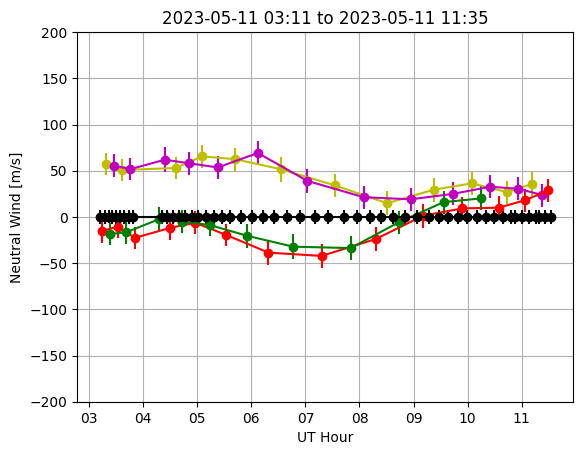

In [19]:
from matplotlib.dates import DateFormatter

plt.errorbar(xr_dataset.time.where(east,drop=True).values,xr_dataset.u.where(east,drop=True),yerr=xr_dataset.ue.where(east,drop=True),fmt='yo-')
plt.errorbar(xr_dataset.time.where(west,drop=True).values,xr_dataset.u.where(west,drop=True),yerr=xr_dataset.ue.where(west,drop=True),fmt='mo-')
plt.errorbar(xr_dataset.time.where(north,drop=True).values,xr_dataset.v.where(north,drop=True),yerr=xr_dataset.ve.where(north,drop=True),fmt='ro-')
plt.errorbar(xr_dataset.time.where(south,drop=True).values,xr_dataset.v.where(south,drop=True),yerr=xr_dataset.ve.where(south,drop=True),fmt='go-')
plt.errorbar(xr_dataset.time.where(vertical,drop=True).values,xr_dataset.w.where(vertical,drop=True),yerr=xr_dataset.we.where(vertical,drop=True),fmt='ko-')
plt.ylim([-200,200])

# Format the x-axis to display only the hour
date_formatter = DateFormatter('%H')
plt.gca().xaxis.set_major_formatter(date_formatter)
time_values = xr_dataset.time.values

## Generate a human-readable date range for the title
start_time = pd.to_datetime(time_values[0]).strftime('%Y-%m-%d %H:%M')
end_time = pd.to_datetime(time_values[-1]).strftime('%Y-%m-%d %H:%M')
plt.title(f'{start_time} to {end_time}')
plt.xlabel('UT Hour')
plt.ylabel('Neutral Wind [m/s]')
plt.grid()